In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from vgg16.vgg16_modified import vgg16_modified
from data_processing import data_handling as dh
import os
from matplotlib import pyplot as plt

In [2]:
# FEAT_DIR = './data/train/images'
# LABELS_DIR = './data/train/masks'
# #VGG_PATH = '/home/paperspace/kaggle/Semantic_Segmentation/vgg16/saved_model_with_dropout'
# VGG_PATH = '/home/paperspace/kaggle/Semantic_Segmentation/vgg16/saved_model_no_weights'
# WEIGHT_PATH = './vgg16/vgg16_weights.npz'
NUM_CLASSES = 1
LRATE = 0.001
EPOCHS = 10
BATCH_SIZE = 64
IMAGE_SHAPE = (101, 101, 3)
LABEL_SHAPE = (101, 101)
INPUT_SHAPE = (104, 104, 3)
OUTPUT_SHAPE = (104, 104)

In [3]:
def optimize(nn_last_layer, correct_label, learning_rate = LRATE, num_classes = NUM_CLASSES):
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name="fcn_logits")
    correct_label_reshaped = tf.reshape(correct_label, (-1, num_classes))
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=correct_label_reshaped[:])
    loss_op = tf.reduce_mean(cross_entropy, name="fcn_loss") # actual loss value
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op, name="fcn_train_op")
    return logits, train_op, loss_op

def train_nn(sess, epochs, batch_size, data_handler, train_op,
             cross_entropy_loss, input_image,
             correct_label, phase_ph):
    
    def check_and_delete_existing(directory):
        if os.path.exists(directory):
            os.system("rm -rf "+directory)
        return directory
    
    output_path = check_and_delete_existing("./Train")
    train_summary_writer = tf.summary.FileWriter(output_path)
    
    train_summary=tf.Summary()
    val_summary=tf.Summary()
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    total_train_loss = 0
    total_val_loss = 0
    step = 0 
    for epoch in range(epochs):
        total_train_loss = 0
        total_val__loss = 0
        for X_batch, gt_batch in data_handler.gen_batch_function(bs = batch_size):
            step += 1
            
            loss, _ = sess.run([cross_entropy_loss, train_op], 
                               feed_dict={input_image: X_batch, 
                                          correct_label: gt_batch,
                                          phase_ph: 1})
            
            val_loss = sess.run([cross_entropy_loss], 
                                feed_dict={input_image: data_handler.val_feat_data, 
                                           correct_label: data_handler.val_label_data, 
                                           phase_ph: 1})
            
            train_summary.value.add(tag='train_loss', simple_value = loss)
            val_summary.value.add(tag='val_loss', simple_value = val_loss[0])
            train_summary_writer.add_summary(train_summary, step)
            train_summary_writer.add_summary(val_summary, step)
            
            # train_summary_writer.flush()
            total_train_loss += loss;
            total_val_loss += val_loss[0]
        print("EPOCH {} ...".format(epoch + 1))
        print("Loss = {:.3f};  Val_loss = {:.3f}".format(total_train_loss, total_val_loss))
        print()
    
    graph = tf.get_default_graph()
    
    output = graph.get_tensor_by_name('final_output:0')
    
    train_pred = sess.run([output], 
             feed_dict={input_image: data_handler.train_feat_data[:5], 
                        correct_label: data_handler.train_label_data[:5], 
                        phase_ph: 0})
    
    test_pred = sess.run([output], 
             feed_dict={input_image: data_handler.val_feat_data[:5], 
                        correct_label: data_handler.val_label_data[:5], 
                        phase_ph: 0})
    
    return (data_handler.train_feat_data[:5], 
            train_pred, data_handler.train_label_data[:5], 
            data_handler.val_feat_data[:5],
            test_pred,
            data_handler.val_label_data[:5]
           )

### Run

In [4]:
with tf.Session() as sess:
    
    d_processor = dh()
    image_input = tf.placeholder(tf.float32,
                          [None, *INPUT_SHAPE],
                          name='image_input'
                         )
    
    phase = tf.placeholder(tf.bool, name='phase') 
    # if no dropout will not be relevant
    
    vgg = vgg16_modified(image_input, sess)

    correct_label = tf.placeholder(tf.float32, 
                                   [None, *OUTPUT_SHAPE], 
                                   name='correct_label'
                                  )

    logits, train_op, cross_entropy_loss = optimize(vgg.output, correct_label)
    
    (input_train,
    train, 
    true_train, 
    input_test, 
    test, 
    true_test) \
    = train_nn(
        sess,
        EPOCHS,
        BATCH_SIZE,
        d_processor,
        train_op, 
        cross_entropy_loss,
        image_input,
        correct_label,
        phase
    )
    
    

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
EPOCH 1 ...
Loss = 295.120;  Val_loss = 566.535

EPOCH 2 ...
Loss = 26.679;  Val_loss = 604.233

EPOCH 3 ...
Loss = 22.901;  Val_loss = 636.666

EPOCH 4 ...
Loss = 20.957;  Val_loss = 667.413

EPOCH 5 ...
Loss = 19.497;  Val_loss = 697.926

EPOCH 6 ...
Loss = 18.145;  Val_loss = 731.294

EPOCH 7 ...
Loss = 16.431;  Val_loss = 764.270

EPOCH 8 ...
Loss = 15.631;  Val_loss = 798.763

EPOCH 9 ...
Loss = 14.607;  Val_loss = 831.982

EPOCH 10 ...
Loss = 14.410;  Val_loss = 869.064



### Evaluation

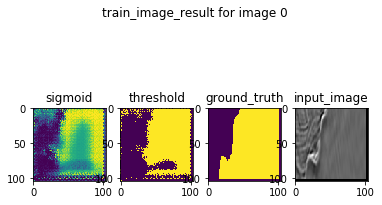

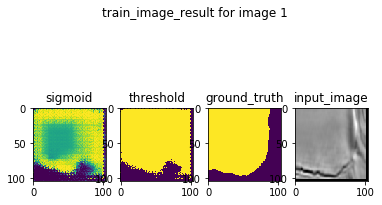

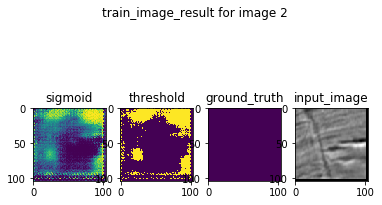

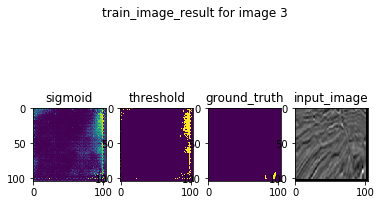

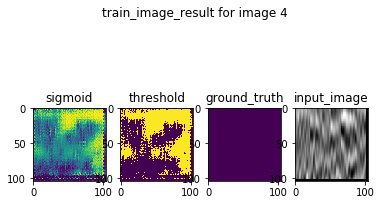

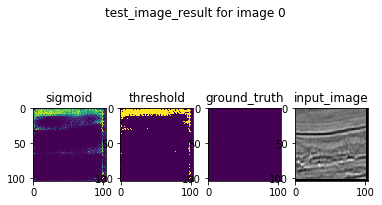

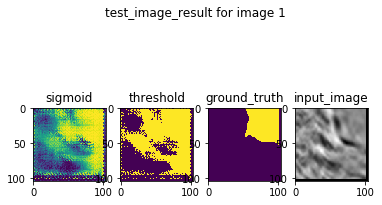

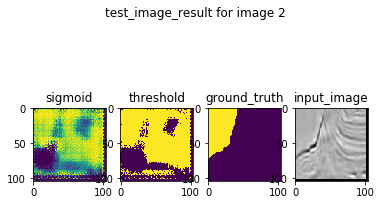

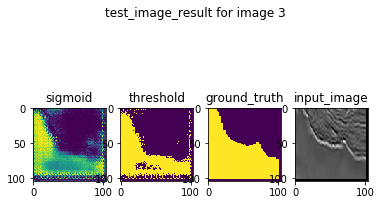

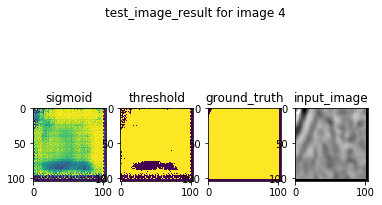

In [9]:
def proc_image(input_img, predict, true, ind, name):
    
    def softmax(x):
        return 1 / (1 + np.exp(-x))
    
    predict = np.array(predict)
    img = predict[0,ind,:,:,0]
    img = np.array(list(map(softmax, img))
                  )
    thresh_img = img > 0.5
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(img)
    ax[0].set_title('sigmoid')
    ax[1].imshow(thresh_img)
    ax[1].set_title('threshold')
    ax[2].imshow(true[ind])
    ax[2].set_title('ground_truth')
    ax[3].imshow(input_img[ind])
    ax[3].set_title('input_image')
    fig.suptitle(name + ' for image ' + str(ind))
    
    return None

for i in range(5):
    proc_image(input_train, train, true_train, i, name = 'train_image_result')

for i in range(5):
    proc_image(input_test, test, true_test, i, name = 'test_image_result')